<a href="https://colab.research.google.com/github/robinrb7/RealWorldSizing/blob/main/Real_World_Sizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install necessary libraries (run this in a Colab cell)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers
!pip install pillow requests supervision exifread

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6

In [3]:
!pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124


In [4]:
# Install PyTorch with CUDA 11.8
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (27 kB)
Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl (848.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.4 MB/s eta 0:00:00


In [5]:
#Step 2: Import Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
import supervision as sv
import exifread

# Hugging Face Transformers
from transformers import (
    AutoProcessor, AutoModelForZeroShotObjectDetection,
    SamModel, SamProcessor, AutoImageProcessor, AutoModelForDepthEstimation
)

In [6]:
#Step 3: Load Models

# Grounding DINO
model_id = "IDEA-Research/grounding-dino-base"
processor = AutoProcessor.from_pretrained(model_id)
detection_model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to("cuda")

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

In [7]:
# Segment Anything Model (SAM)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [9]:
# Depth Anything
image_processor_id = "depth-anything/Depth-Anything-V2-Small-hf"
depth_processor = AutoImageProcessor.from_pretrained(image_processor_id)
depth_model = AutoModelForDepthEstimation.from_pretrained(image_processor_id).to("cuda")

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

In [137]:
#Step 4: Load and Process Image

# Load image
image_path = "/content/ex3.jpg"
image = Image.open(image_path)

In [138]:
# Define text prompt
text_prompt = "a bottle. a cup."  # Replace with your object description

# Preprocess image and text prompt
inputs = processor(images=image, text=text_prompt, return_tensors="pt").to("cuda")

# Run Grounding DINO
with torch.no_grad():
    outputs = detection_model(**inputs)

# Post-process results
target_sizes = [image.size[::-1]]  # (height, width)
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.27,
    text_threshold=0.35,
    target_sizes=target_sizes
)

In [139]:
# Extract bounding boxes, labels, and scores
boxes = results[0]["boxes"].cpu().numpy()
labels = results[0]["labels"]
scores = results[0]["scores"].cpu().numpy()

In [152]:
print(boxes)

[[1772.5995 2849.7314 2920.6777 4554.765 ]
 [ 663.1291 1594.5131 1895.9703 4553.5435]]


In [140]:
#Step 5: Segment Objects Using SAM

def calculate_pixel_dimensions(mask):
    # Ensure mask is 2D
    if mask.ndim > 2:
        mask = mask[0]  # Select the first channel (or use np.mean(mask, axis=0) for averaging)
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return 0, 0  # No mask found
    height = np.max(y_indices) - np.min(y_indices)
    width = np.max(x_indices) - np.min(x_indices)
    return width, height

Mask shape: (3, 4624, 3472)


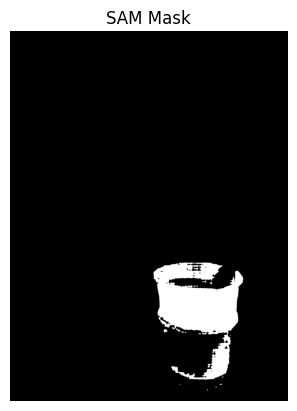

Object 1 (a cup): Width = 1119, Height = 1599
Mask shape: (3, 4624, 3472)


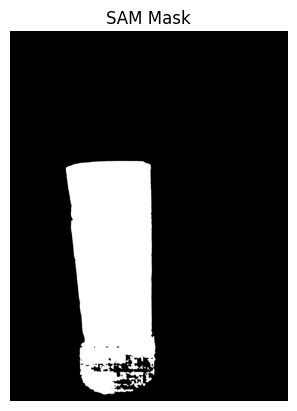

Object 2 (a bottle): Width = 1121, Height = 2919


In [141]:
# Process each detected object
for idx, (box, label, score) in enumerate(zip(boxes, labels, scores)):
    if len(box) == 4 and score > 0.25:  # Filter by confidence score
        x_min, y_min, x_max, y_max = box

        # Use the bounding box center as the input point for SAM
        input_points = [[[(x_min + x_max) / 2, (y_min + y_max) / 2]]]

        # Prepare inputs for SAM
        inputs_sam = sam_processor(
            image,
            input_points=input_points,
            return_tensors="pt"
        ).to("cuda")

        # Run SAM
        with torch.no_grad():
            outputs_sam = sam_model(**inputs_sam)

        # Post-process SAM masks
        masks = sam_processor.image_processor.post_process_masks(
            outputs_sam.pred_masks.cpu(),
            inputs_sam["original_sizes"].cpu(),
            inputs_sam["reshaped_input_sizes"].cpu(),
        )
        mask = masks[0].squeeze().numpy()  # Get the first mask

        # Debug: Print mask shape and visualize
        print(f"Mask shape: {mask.shape}")
        plt.imshow(mask[0], cmap="gray")  # Visualize the first channel
        plt.title("SAM Mask")
        plt.axis("off")
        plt.show()

        # Calculate pixel width and height
        width, height = calculate_pixel_dimensions(mask)
        print(f"Object {idx + 1} ({label}): Width = {width}, Height = {height}")

In [142]:
#Step 6: Estimate Depth Using Depth Anything

# Run depth estimation
inputs_depth = depth_processor(images=image, return_tensors="pt").to("cuda")
with torch.no_grad():
    outputs_depth = depth_model(**inputs_depth)
    predicted_depth = outputs_depth.predicted_depth

In [143]:
# Resize depth map to match original image
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [144]:
depth_map = prediction.squeeze().cpu().numpy()

In [145]:
#Step 7: Extract Focal Length from Image Metadata

def get_focal_length(image_path):
    with open(image_path, "rb") as f:
        tags = exifread.process_file(f)

    # Extract Focal Length
    focal_length = tags.get("EXIF FocalLength", "N/A")
    if focal_length != "N/A":
        focal_length = focal_length.values[0].num / focal_length.values[0].den
    return focal_length

In [146]:
# Get and print focal length
focal_length = get_focal_length(image_path)
print(f"📷 Focal Length: {focal_length} mm")

📷 Focal Length: 4.74 mm


In [147]:
#Step 8: Calculate Real-World Size of Objects

def get_object_depth():
    object_depths = {}

    for idx, (box, label) in enumerate(zip(boxes, labels)):
        if len(box) == 4:
            x_min, y_min, x_max, y_max = map(int, box)
            object_depth = depth_map[y_min:y_max, x_min:x_max]
            avg_depth = np.mean(object_depth)
            object_name = f"{label}_{idx + 1}"
            object_depths[object_name] = avg_depth

    return object_depths

In [148]:
# Get average depth for each object
object_depths = get_object_depth()

In [149]:
# Calculate real-world size
for obj, depth in object_depths.items():
    # Get pixel dimensions (replace with actual values)
    width, height = calculate_pixel_dimensions(mask)  # Assuming masks are available

    # Calculate real-world size
    real_width = (width * depth) / focal_length
    real_height = (height * depth) / focal_length
    print(f"{obj}: Real Width = {real_width:.2f} inches, Real Height = {real_height:.2f} meters")

a cup_1: Real Width = 1112.53 inches, Real Height = 2896.95 meters
a bottle_2: Real Width = 992.58 inches, Real Height = 2584.61 meters


In [150]:
#Step 9: Visualize Results

def visualize_results():
    draw = ImageDraw.Draw(image)

    for box, score, label in zip(boxes, scores, labels):
        if len(box) == 4 and score > 0.25:  # Use threshold to filter boxes
            x_min, y_min, x_max, y_max = box
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=15)
            draw.text((x_min, y_min), f"{label}: {score:.2f}", fill="red")

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Detected Objects")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(depth_map, cmap="viridis")
    plt.title("Depth Map")
    plt.axis("off")
    plt.show()

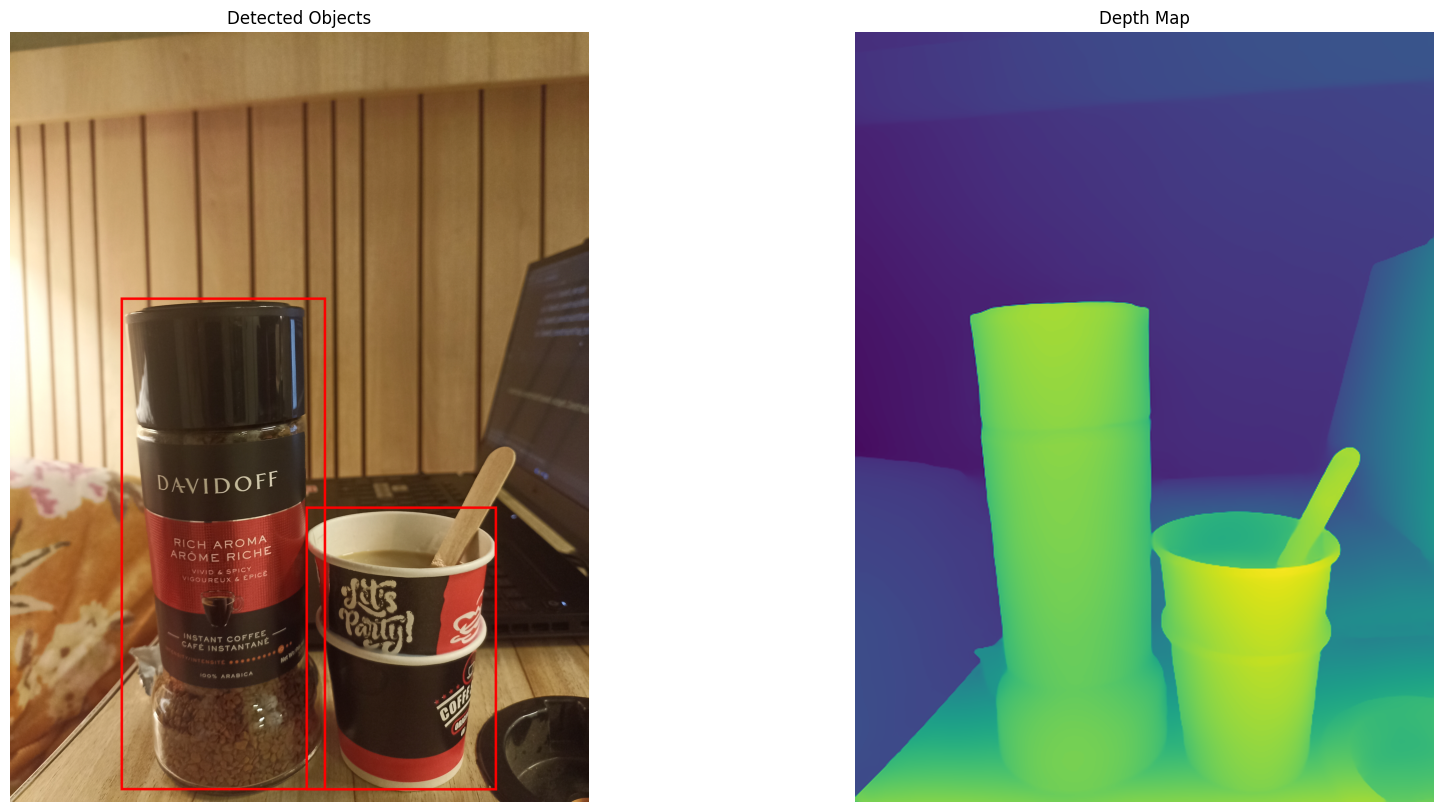

In [151]:
# Visualize results
visualize_results()